In [4]:
# import the necessary libraries
import re
import requests
import random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from time import sleep
from bs4 import BeautifulSoup
import os

# global properties
# data_dir = "data/" # where to save data
# num_search_pages = 50 # how many search pages to cull through

# NOTE:
# if you haven't yet downloaded the data, this should be set to True
download_data = False

In [5]:
# World COVID Data
# Import data from .csv file
world_covid_fname = os.path.join("1_owid",
                     "owid-covid-data.csv")
world_covid_df = pd.read_csv(world_covid_fname)

eu_covid_fname = os.path.join("2_ecdc", "testing.csv")
    # also admissionrates, agerangenotificationeu, country_response_measures, dailynotificationeu
    # notification, testing, weeklynotificationeu
eu_testing_df = pd.read_csv(eu_covid_fname)

alabama_covid_fname = os.path.join("3_covidtracking", "alabama-history.csv")
us_covid_fname = os.path.join("3_covidtracking", "national-history.csv")
alabama_covid_df = pd.read_csv(alabama_covid_fname)
us_covid_df = pd.read_csv(us_covid_fname)
# world_covid_df

Data Cleaning

In [6]:
# will use the world covid data for now
world_covid_df["location"].value_counts() # 192 countries

Mexico              370
Thailand            367
Taiwan              355
South Korea         350
World               349
                   ... 
Solomon Islands      85
Hong Kong            71
Marshall Islands     69
Vanuatu              56
Samoa                48
Name: location, Length: 192, dtype: int64

In [7]:
# checking null values
world_covid_df[world_covid_df["total_deaths"].isnull()] #wonder if we can impute total deaths based on previous values?
# about 8000 rows have NaN total deaths across 187 countries
world_covid_df[~world_covid_df["extreme_poverty"].isnull()]
#check reproduction rate - seems to have a lot of nulls

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
316,ALB,Europe,Albania,2020-03-09,2.0,2.0,NaN,NaN,NaN,NaN,...,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
317,ALB,Europe,Albania,2020-03-10,10.0,8.0,NaN,NaN,NaN,NaN,...,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
318,ALB,Europe,Albania,2020-03-11,12.0,2.0,NaN,1.0,1.0,NaN,...,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
319,ALB,Europe,Albania,2020-03-12,23.0,11.0,NaN,1.0,0.0,NaN,...,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
320,ALB,Europe,Albania,2020-03-13,33.0,10.0,NaN,1.0,0.0,NaN,...,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58149,ZWE,Africa,Zimbabwe,2020-12-16,11749.0,227.0,106.000,313.0,3.0,1.286,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.70,61.49,0.535
58150,ZWE,Africa,Zimbabwe,2020-12-17,11866.0,117.0,112.143,314.0,1.0,1.286,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.70,61.49,0.535
58151,ZWE,Africa,Zimbabwe,2020-12-18,12047.0,181.0,126.429,316.0,2.0,1.429,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.70,61.49,0.535
58152,ZWE,Africa,Zimbabwe,2020-12-19,12151.0,104.0,133.143,318.0,2.0,1.571,...,1899.775,21.4,307.846,1.82,1.6,30.7,36.791,1.70,61.49,0.535


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118a1d908>]],
      dtype=object)

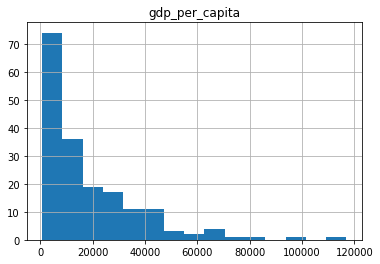

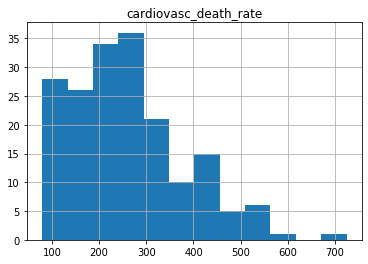

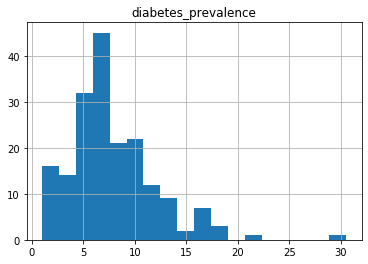

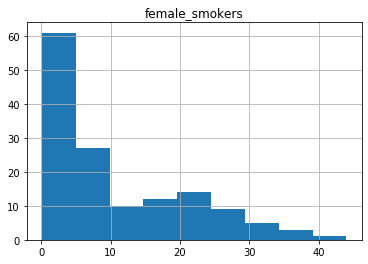

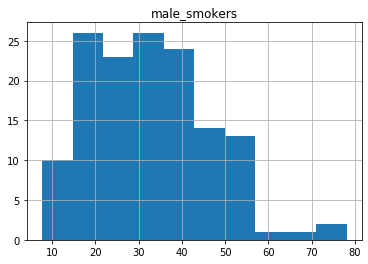

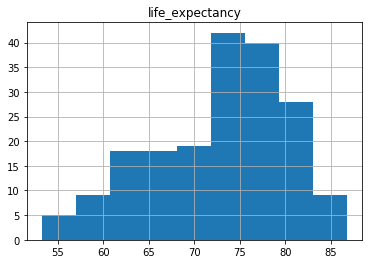

In [8]:
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="gdp_per_capita", bins='auto')
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="cardiovasc_death_rate", bins='auto')
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="diabetes_prevalence", bins='auto')
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="female_smokers", bins='auto')
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="male_smokers", bins='auto')
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="life_expectancy", bins='auto')




In [9]:
world_covid_df[world_covid_df["date"]=="2021-01-01"].sort_values(by=['total_deaths'], ascending=True)[0:15][['location', 'total_deaths', 'total_cases', 'positive_rate', 'stringency_index', 'population_density', 'gdp_per_capita', 'cardiovasc_death_rate']]


,location,total_deaths,total_cases,positive_rate,stringency_index,population_density,gdp_per_capita,cardiovasc_death_rate
35031,Mongolia,1.0,1242.0,NaN,NaN,1.980,11840.846,460.043
16886,Eritrea,1.0,1252.0,NaN,NaN,44.304,1510.459,311.110
8581,Burundi,2.0,822.0,NaN,NaN,423.062,702.225,293.068
18136,Fiji,2.0,49.0,NaN,NaN,49.562,8702.975,412.820
7697,Brunei,3.0,157.0,NaN,NaN,81.347,71809.251,201.285
34730,Monaco,3.0,885.0,NaN,NaN,19347.500,NaN,NaN
1827,Antigua and Barbuda,5.0,159.0,NaN,NaN,231.845,21490.943,191.511
43972,Saint Lucia,5.0,353.0,NaN,NaN,293.187,12951.839,204.620
4658,Barbados,7.0,395.0,NaN,NaN,664.463,16978.068,170.050
51321,Taiwan,7.0,802.0,0.006,NaN,NaN,NaN,103.957


In [10]:
world_covid_df[world_covid_df["date"]=="2021-01-01"].sort_values(by=['gdp_per_capita'], ascending=False)[0:15][['location', 'total_deaths', 'total_cases', 'positive_rate', 'stringency_index', 'population_density', 'gdp_per_capita', 'cardiovasc_death_rate']]

,location,total_deaths,total_cases,positive_rate,stringency_index,population_density,gdp_per_capita,cardiovasc_death_rate
42438,Qatar,245.0,144042.0,0.045,56.48,227.322,116935.600,176.690
31245,Luxembourg,495.0,46415.0,NaN,83.33,231.447,94277.965,128.275
46764,Singapore,29.0,58629.0,NaN,NaN,7915.731,85535.383,92.243
7697,Brunei,3.0,157.0,NaN,NaN,81.347,71809.251,201.285
25398,Ireland,2248.0,93532.0,0.086,NaN,69.874,67335.293,126.459
54673,United Arab Emirates,671.0,209678.0,0.010,NaN,112.442,67293.483,317.840
28256,Kuwait,936.0,150869.0,0.080,NaN,232.128,65530.537,132.235
39026,Norway,436.0,49803.0,0.037,NaN,14.462,64800.057,114.316
50677,Switzerland,7704.0,452296.0,NaN,60.19,214.243,57410.166,99.739
44630,San Marino,59.0,2428.0,NaN,70.37,556.667,56861.470,NaN


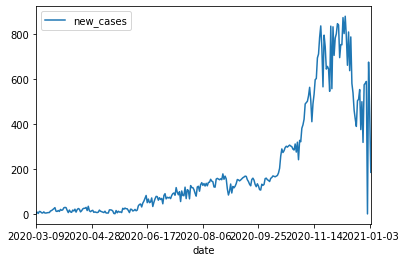

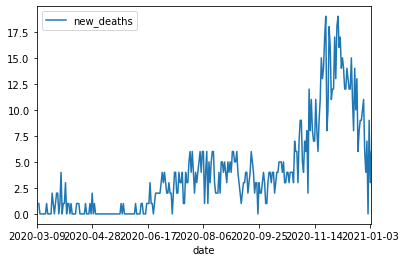

In [11]:

albania_df = world_covid_df[world_covid_df["location"]=="Albania"] #~300 rows per country
albania_df.plot(x='date', y='new_cases', kind='line') 
plt.show()
albania_df.plot(x='date', y='new_deaths', kind='line') 
plt.show()

# Processing World COVID Data
Cleaning and EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e468f60>]],
      dtype=object)

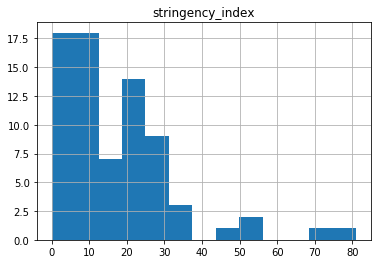

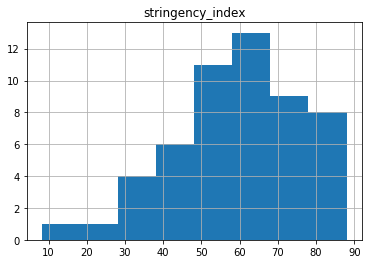

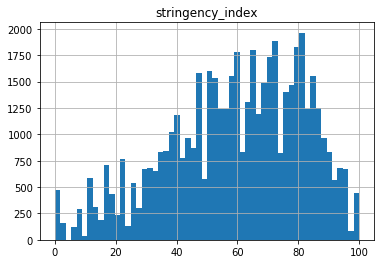

In [12]:
world_covid_df[world_covid_df["date"]=="2020-03-01"].hist(column="stringency_index", bins='auto')
world_covid_df[world_covid_df["date"]=="2021-01-01"].hist(column="stringency_index", bins='auto')
world_covid_df.hist(column="stringency_index", bins='auto')

In [13]:
world_covid_df = world_covid_df[~world_covid_df["stringency_index"].isnull()] # drop ~7000 rows w/o stringency index
world_covid_df = world_covid_df[~world_covid_df["total_cases_per_million"].isnull()] # drop 543 rows w null total cases

# Fill in missing total tests 
all_locations = world_covid_df["location"].unique() # this is a numpy array
locations_w_no_test_data = []
for loc in all_locations:
    loc_df = world_covid_df[world_covid_df["location"]==loc]
    if len(loc_df[~loc_df["total_tests"].isnull()]) == 0:
        locations_w_no_test_data.append(loc)
#     else:
#         print(len(loc_df[~loc_df["total_tests"].isnull()]), len(loc_df))
#         loc_df.hist(column="stringency_index", bins='auto')
#         break
print(f"{len(locations_w_no_test_data)} countries have no test data at all. \
If we exclude these we have {171 - len(locations_w_no_test_data)} countries to work with.")

# Create DF with only locations with some test data
locations_w_test_data = [i for i in all_locations if i not in locations_w_no_test_data]
locations_w_test_data_df = world_covid_df[world_covid_df["location"].isin(locations_w_test_data)]
# locations_w_test_data[locations_w_test_data["total_tests"].isnull()] 

#Split into time frames
early_df = locations_w_test_data_df[(locations_w_test_data_df["date"] >= "2020-03-01")
                                  & (locations_w_test_data_df["date"] <= "2020-03-31")] 
late_df = locations_w_test_data_df[(locations_w_test_data_df["date"] >= "2020-12-01")
                                  & (locations_w_test_data_df["date"] <= "2020-12-31")]
print("March dataset size:", len(early_df), "December dataset size:", len(late_df)) #March 2020 and December 2020 - comparable data sizes

# Impute missing test data
# early_df = early_df[early_df["location"]]

68 countries have no test data at all. If we exclude these we have 103 countries to work with.
March dataset size: 2693 December dataset size: 2467


## Impute Missing Data

Locations with partial missing test data
Australia


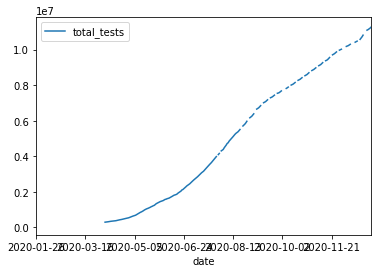

Austria


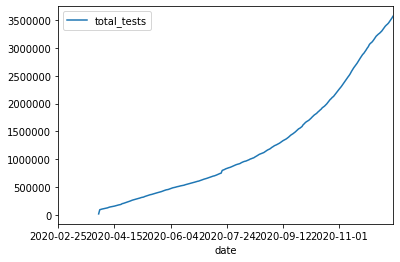

Bahrain


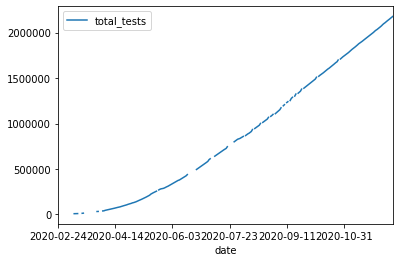

Bangladesh


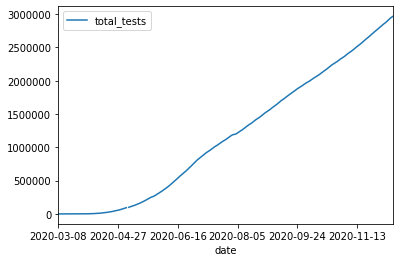

Belarus


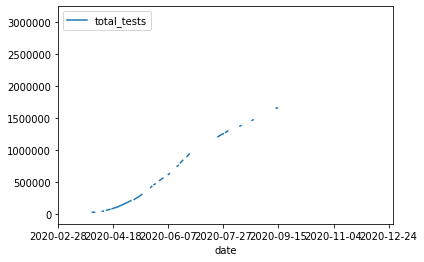

Belgium


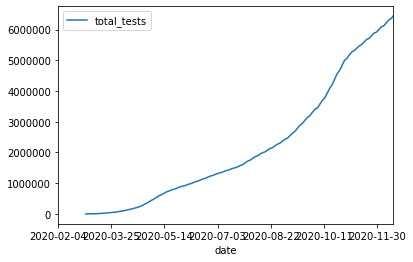

Bolivia


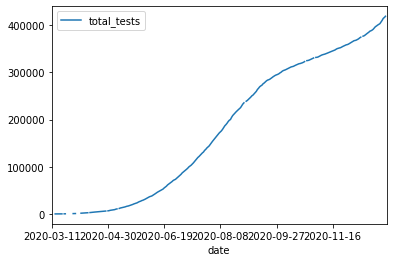

Brazil


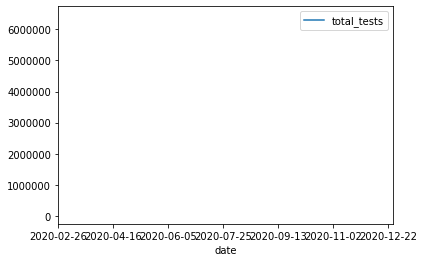

Bulgaria


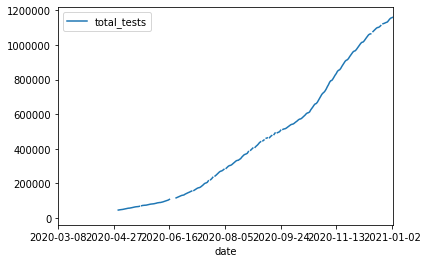

Canada


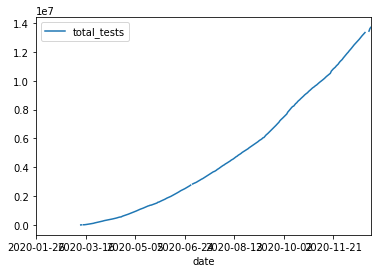

Chile


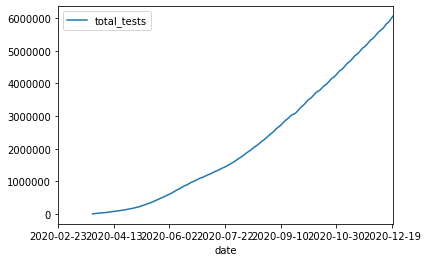

China


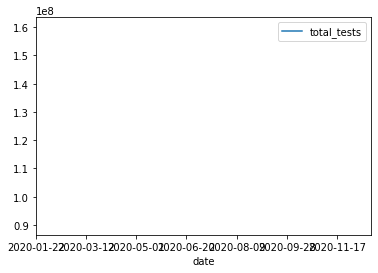

Colombia


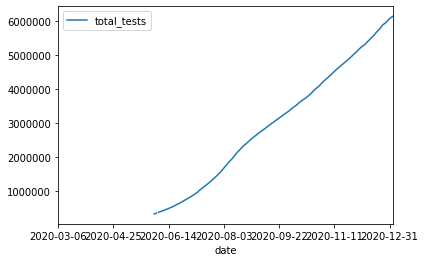

Costa Rica


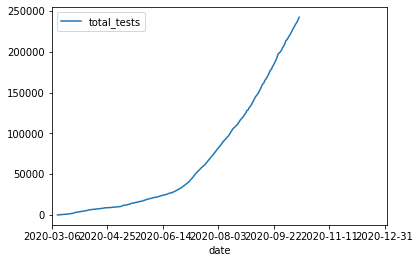

Cote d'Ivoire


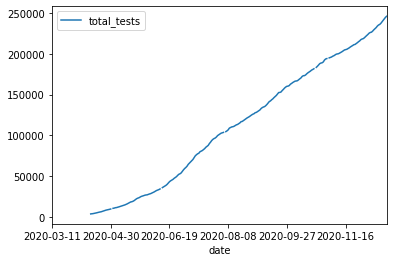

Croatia


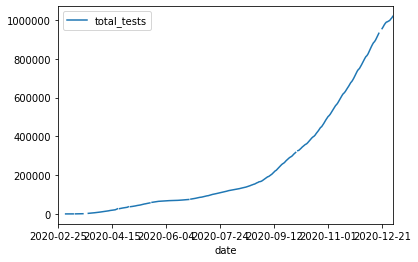

Cuba


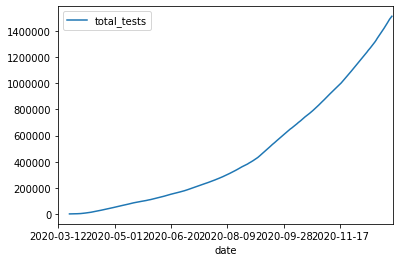

Cyprus


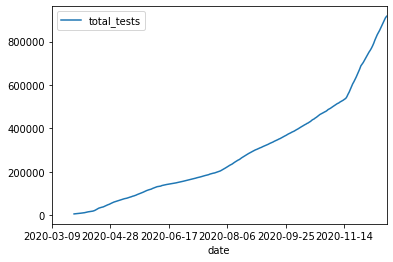

Dominican Republic


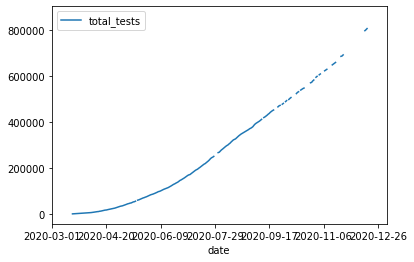

Ecuador


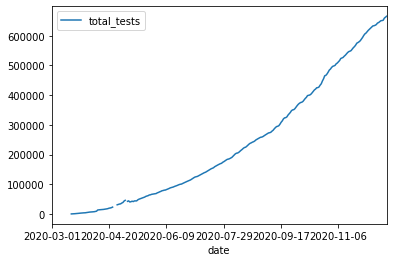

El Salvador


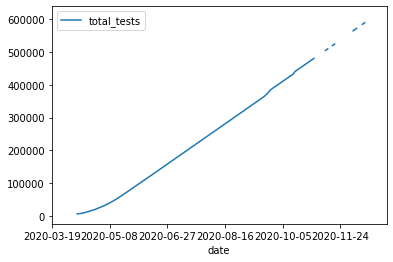

Ethiopia


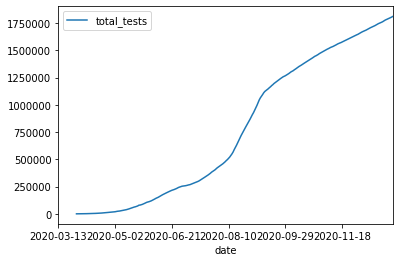

Fiji


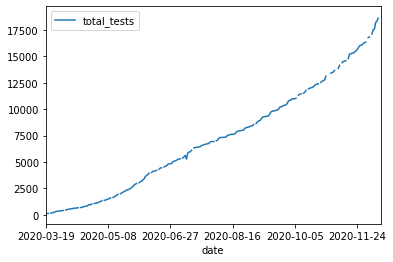

Finland


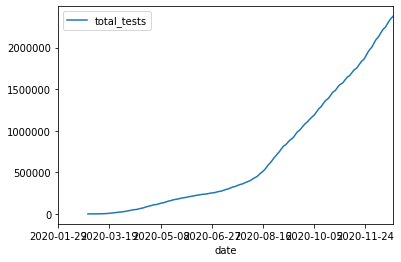

Germany


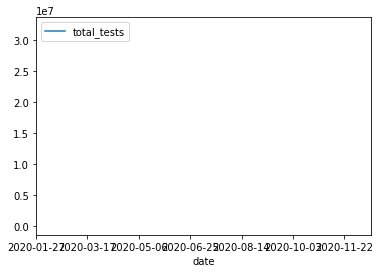

Ghana


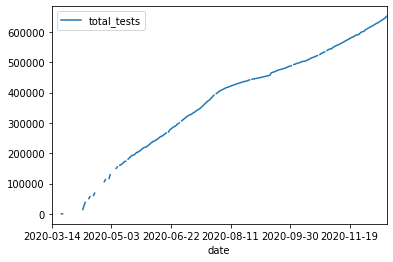

Greece


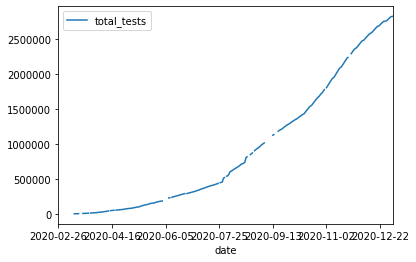

Guatemala


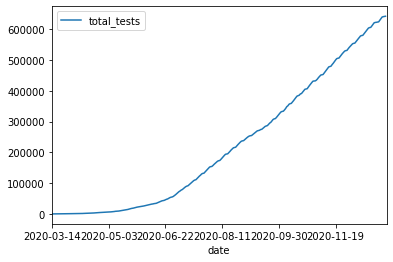

Hungary


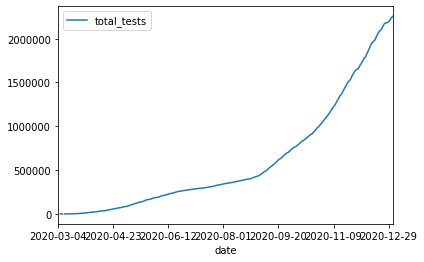

India


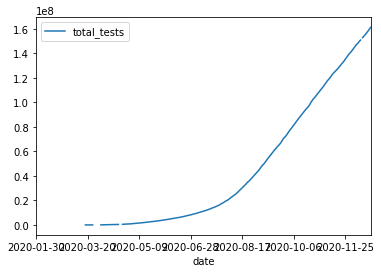

Indonesia


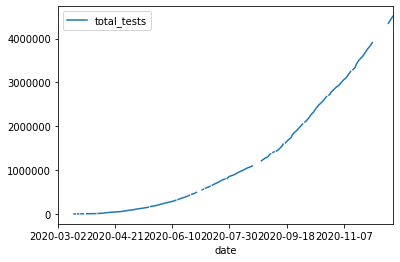

Iran


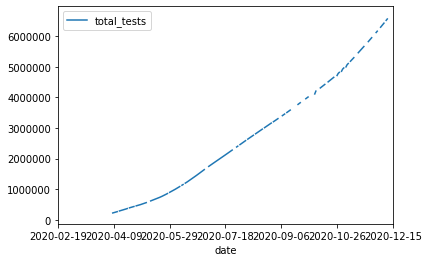

Iraq


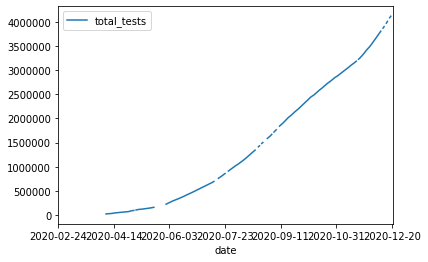

Ireland


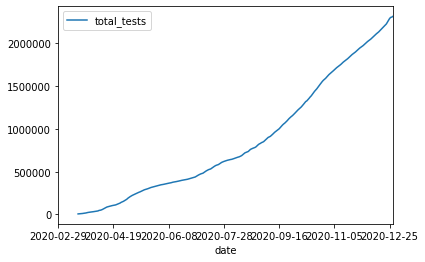

Italy


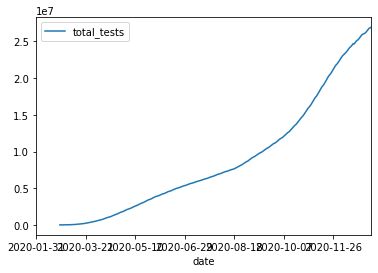

Jamaica


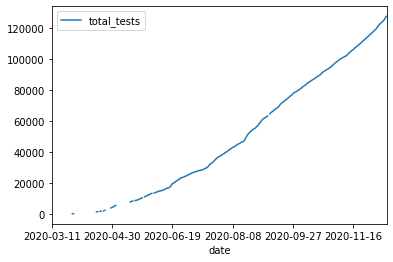

Japan


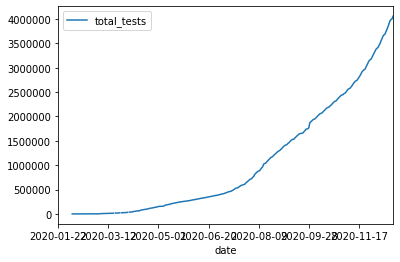

Jordan


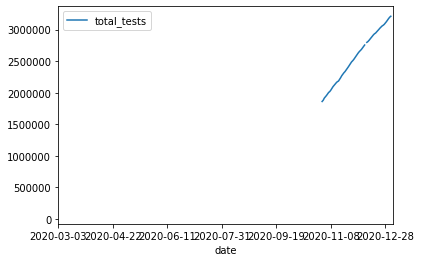

Kazakhstan


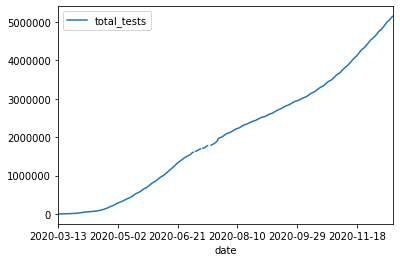

Kenya


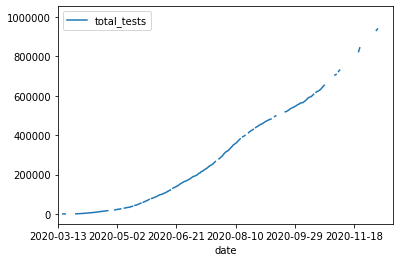

Kuwait


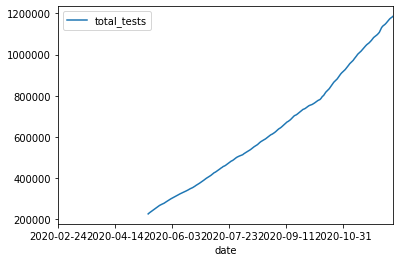

Lithuania


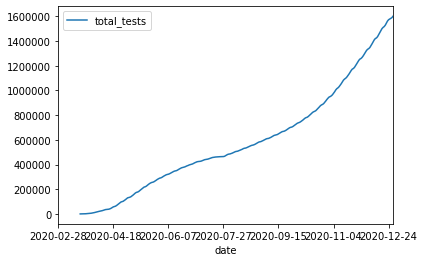

Luxembourg


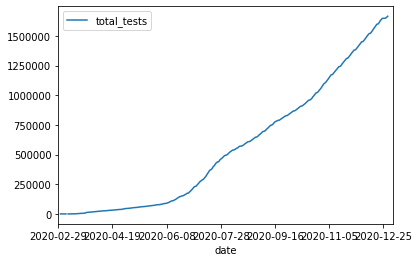

Madagascar


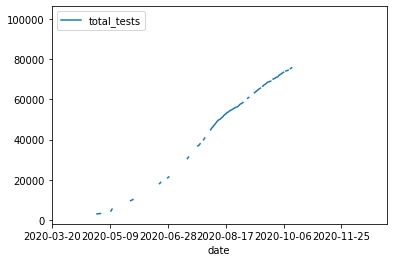

Malawi


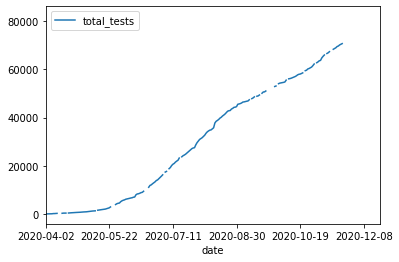

Malaysia


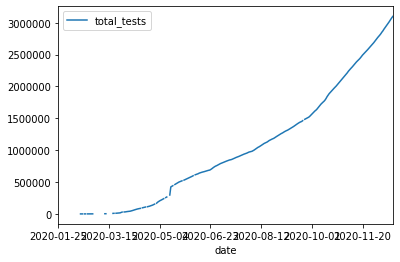

Malta


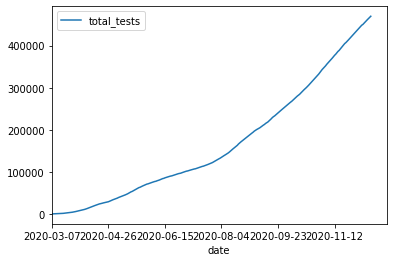

Mauritania


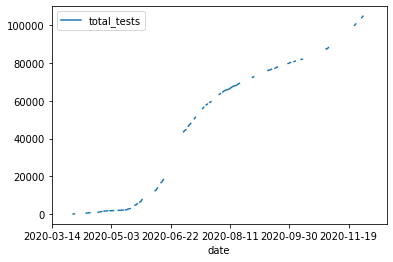

Mexico


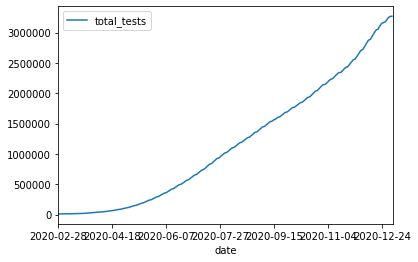

Morocco


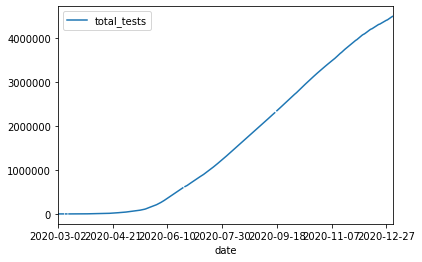

Mozambique


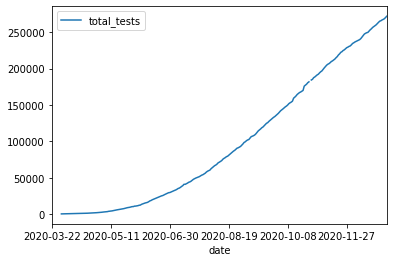

Myanmar


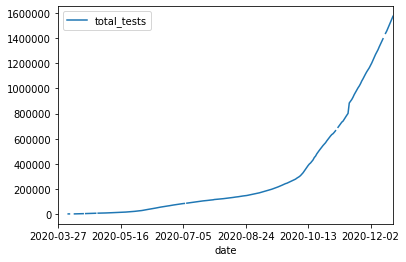

Namibia


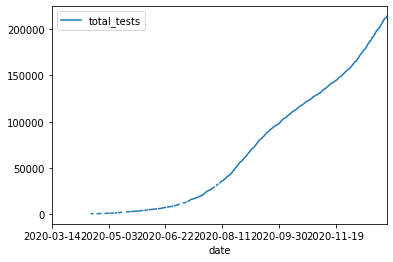

Nepal


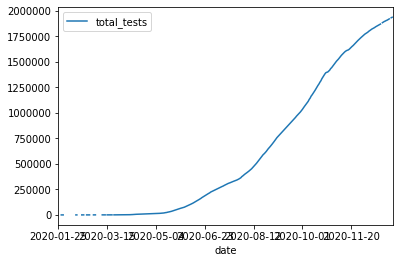

Netherlands


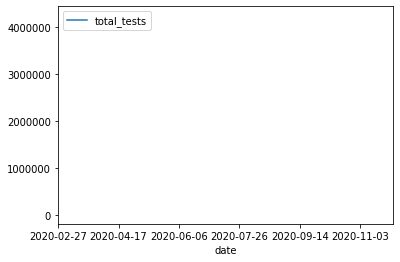

New Zealand


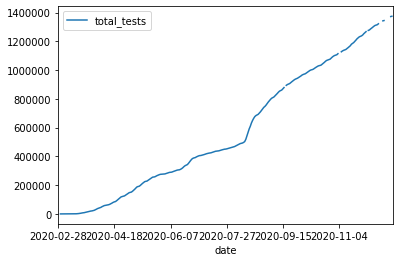

Nigeria


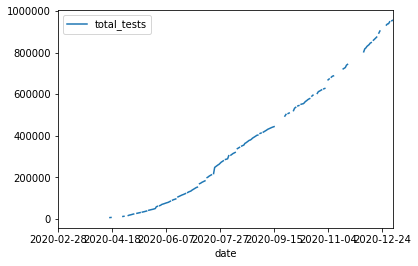

Pakistan


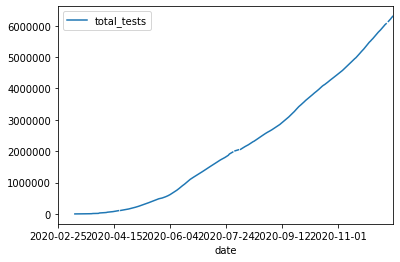

Panama


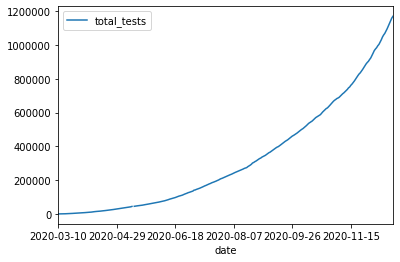

Paraguay


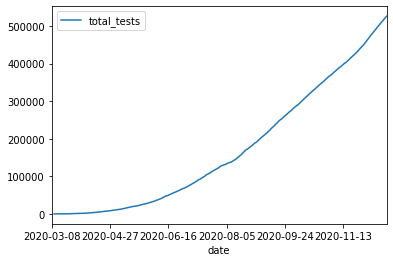

Philippines


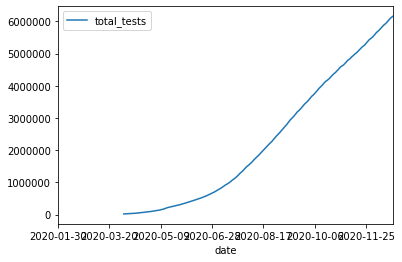

Poland


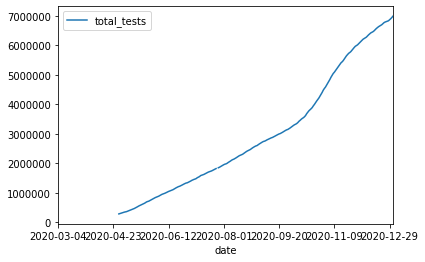

Qatar


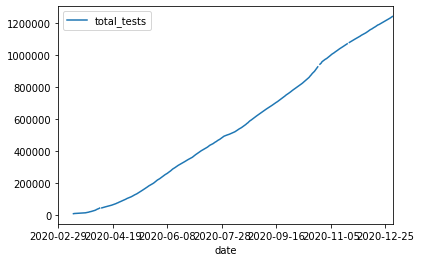

Romania


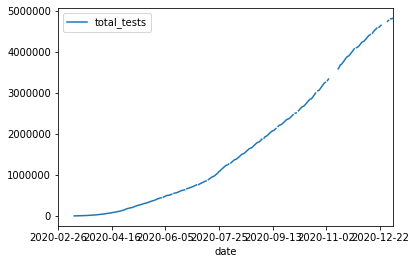

Russia


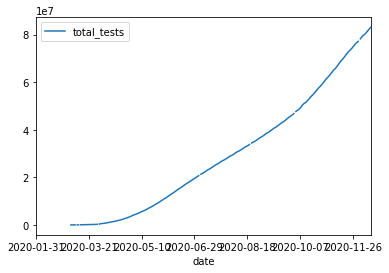

Rwanda


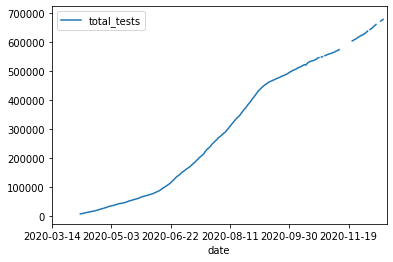

Senegal


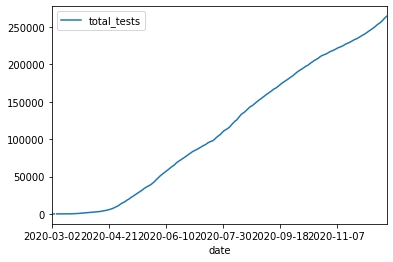

Singapore


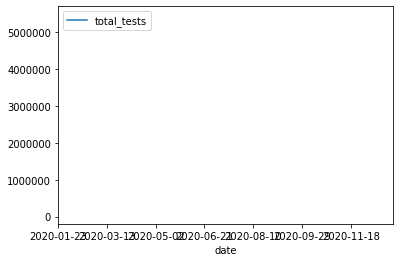

Slovenia


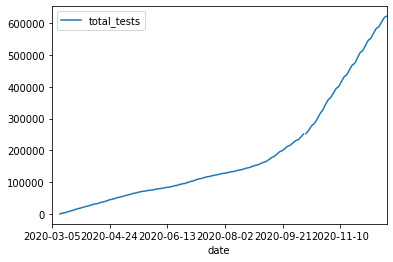

South Africa


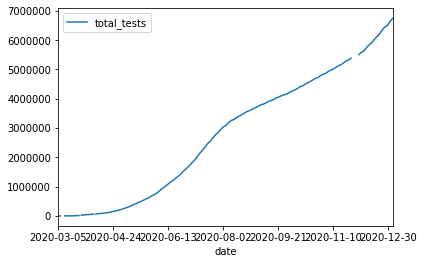

South Korea


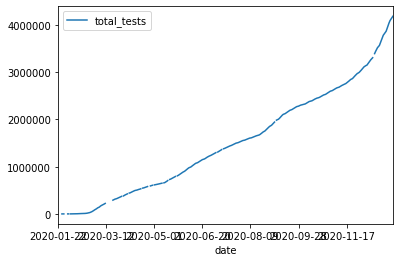

South Sudan


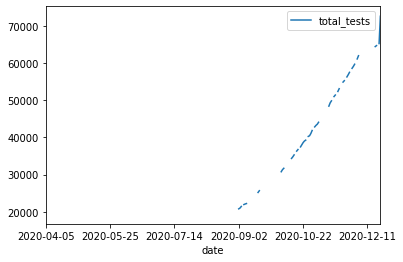

Spain


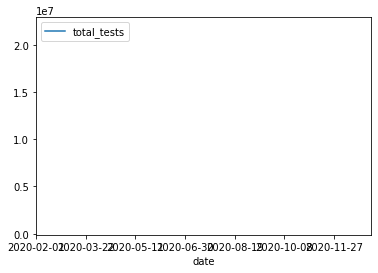

Sri Lanka


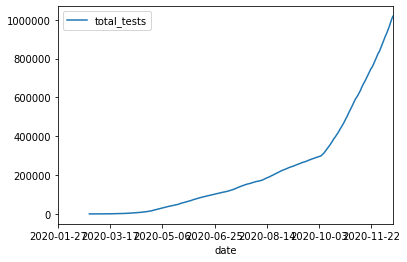

Switzerland


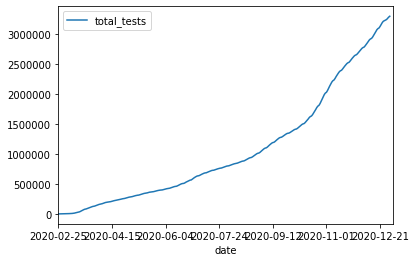

Togo


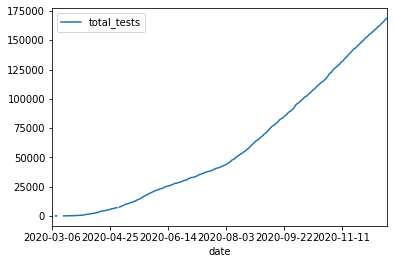

Trinidad and Tobago


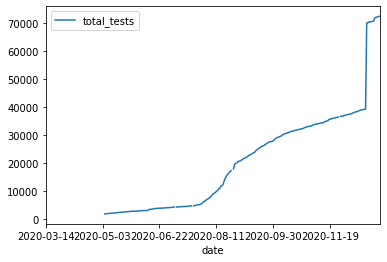

Tunisia


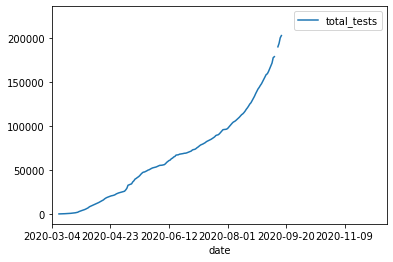

Turkey


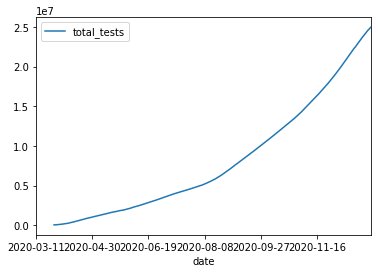

Uganda


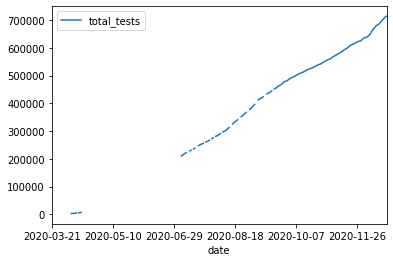

Ukraine


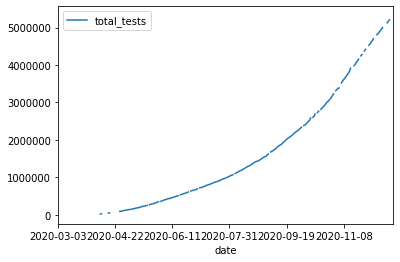

United Arab Emirates


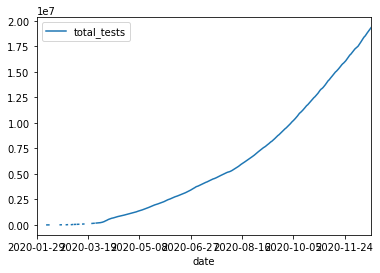

United Kingdom


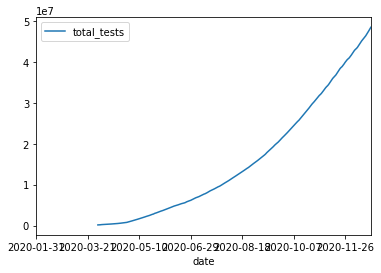

United States


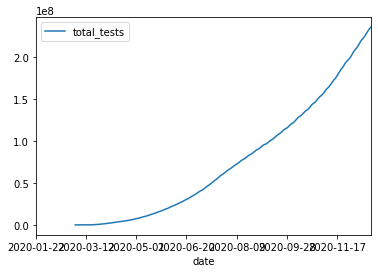

Uruguay


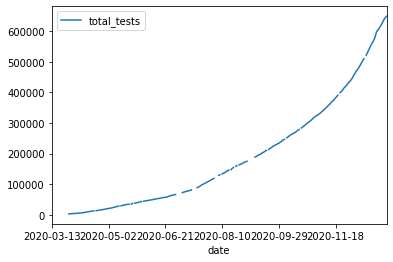

Vietnam


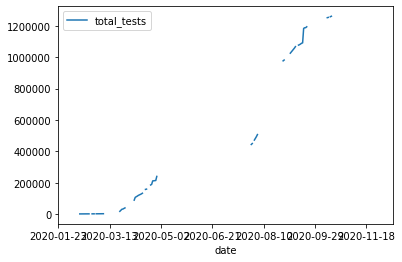

Zambia


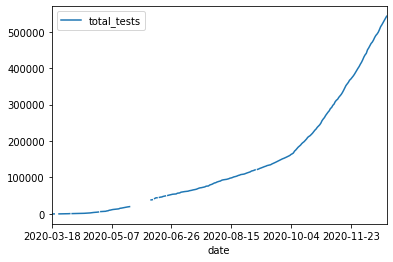

Zimbabwe


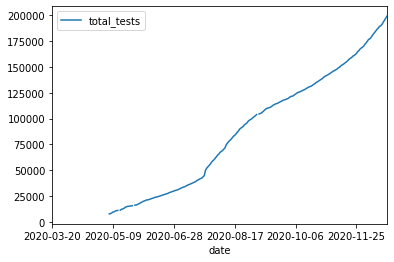

In [15]:
# what does the missing test data look like
print("Locations with partial missing test data")
for loc in locations_w_test_data:
    loc_df = locations_w_test_data_df[locations_w_test_data_df["location"]==loc]
    num_missing = loc_df["total_tests"].isna().sum()
    if num_missing>0:
        # print and show missing test data -> mostly monotonically increasing
        print(loc)
        loc_df.plot(x='date', y='total_tests', kind='line') 
        plt.show()

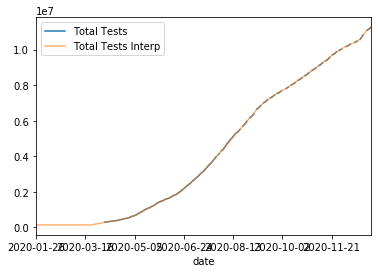

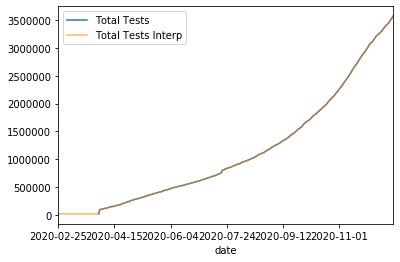

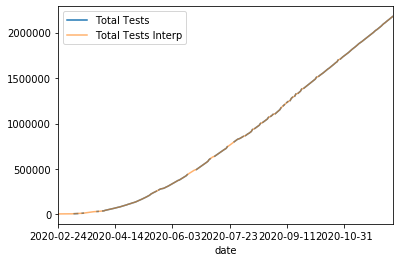

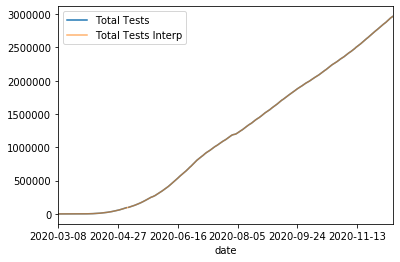

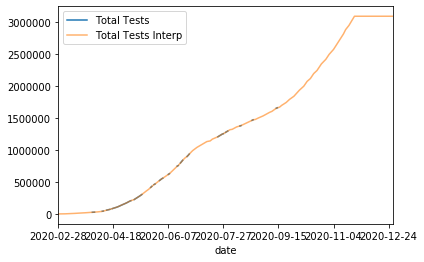

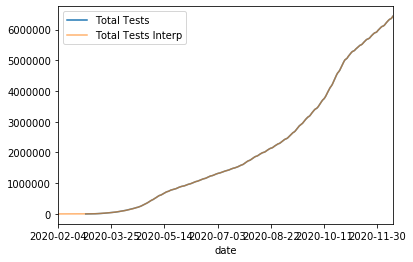

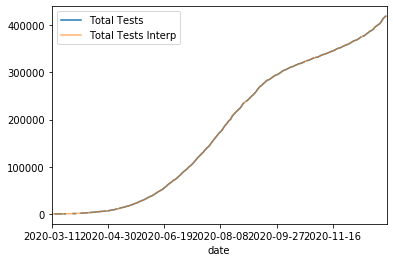

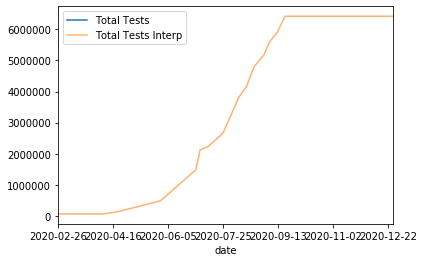

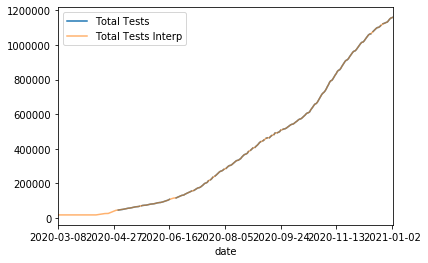

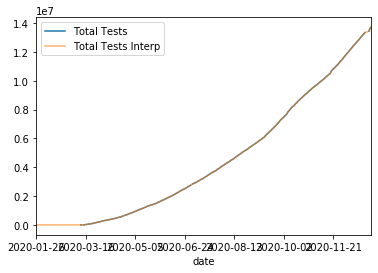

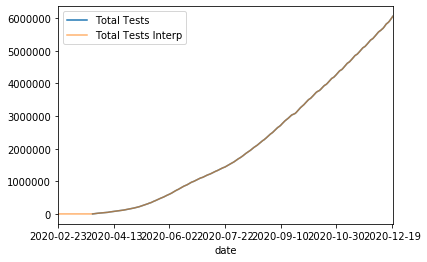

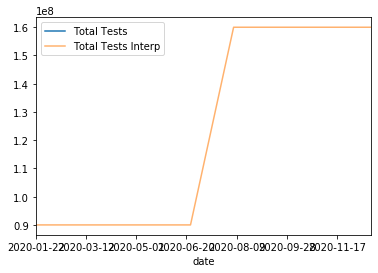

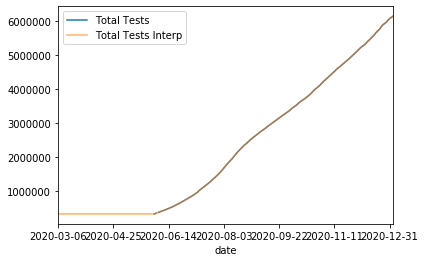

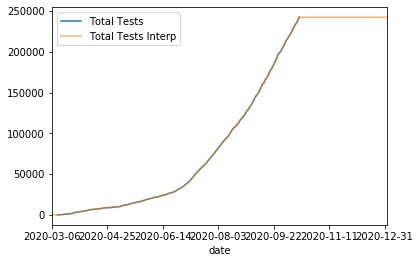

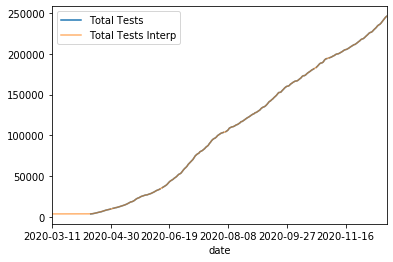

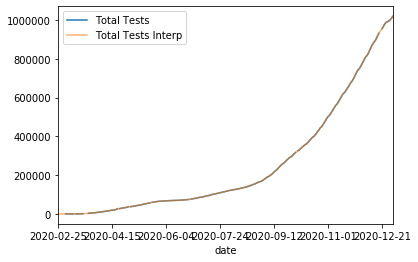

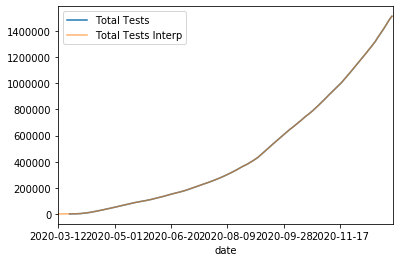

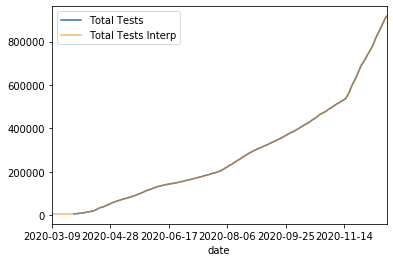

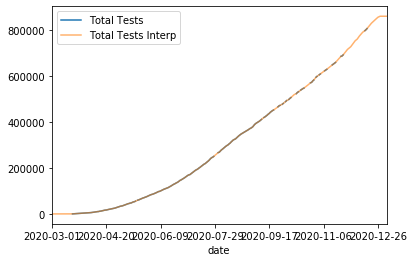

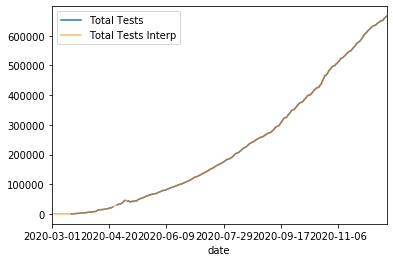

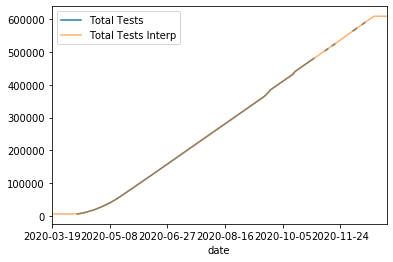

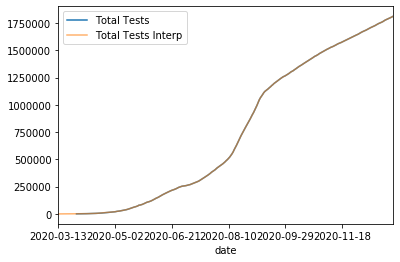

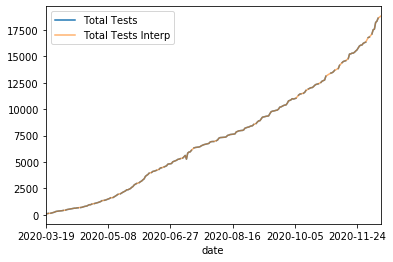

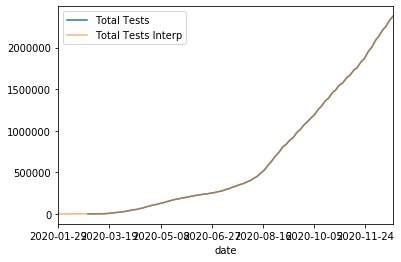

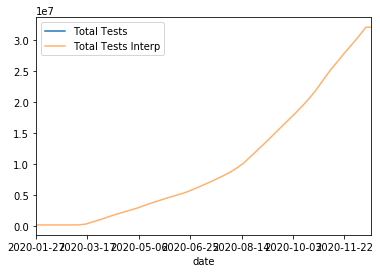

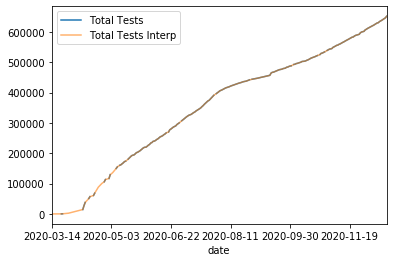

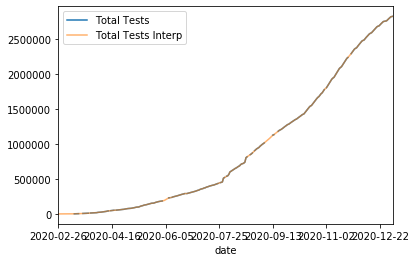

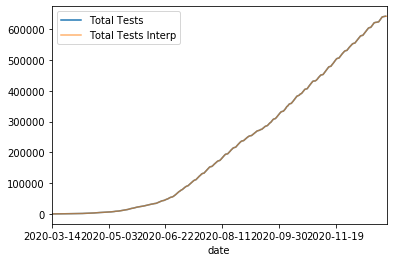

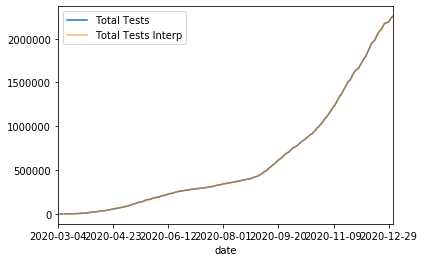

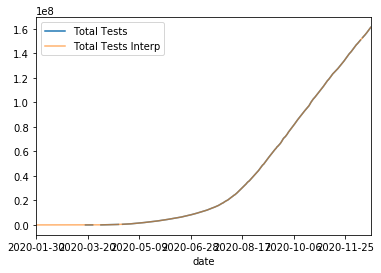

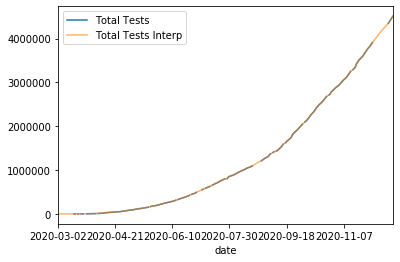

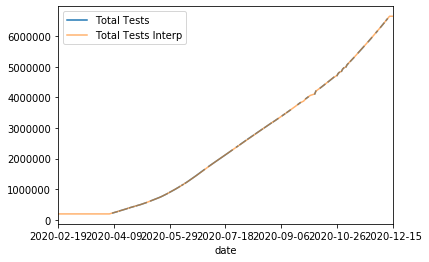

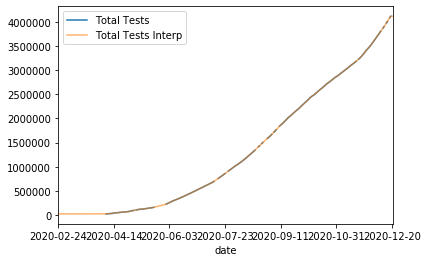

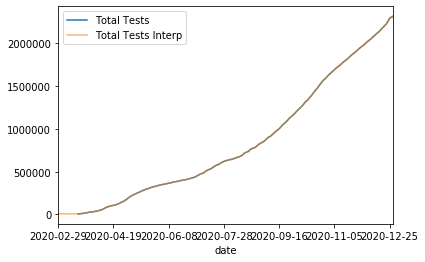

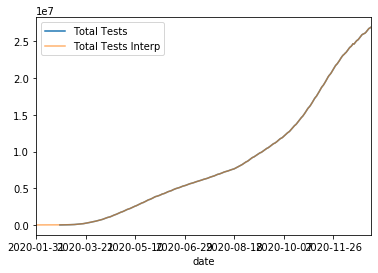

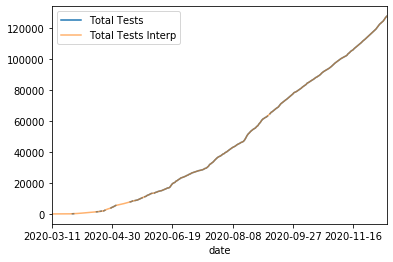

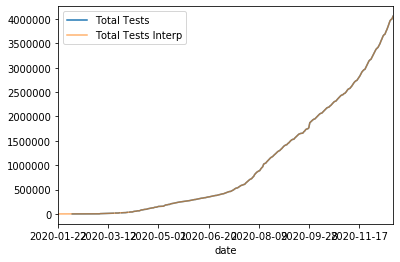

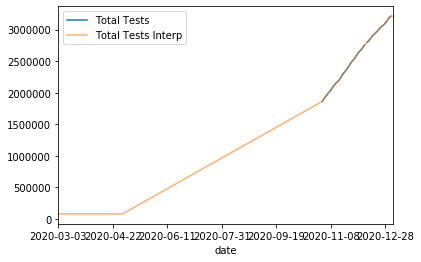

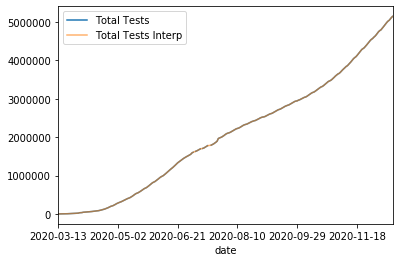

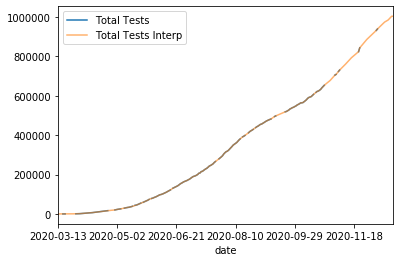

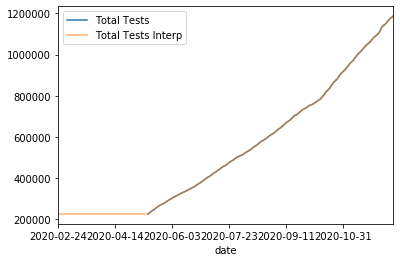

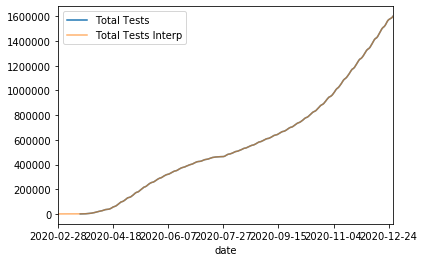

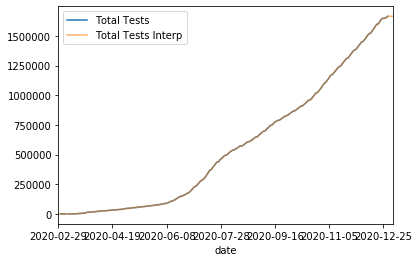

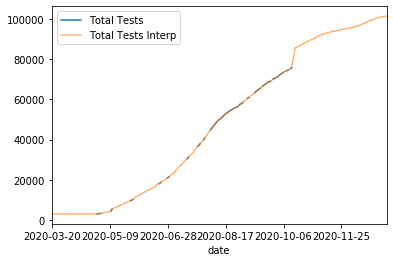

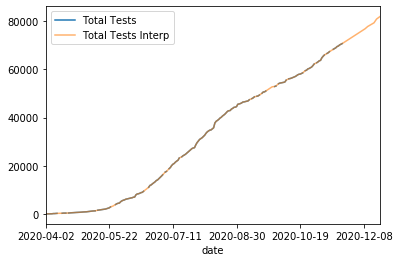

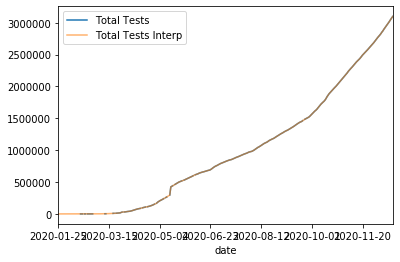

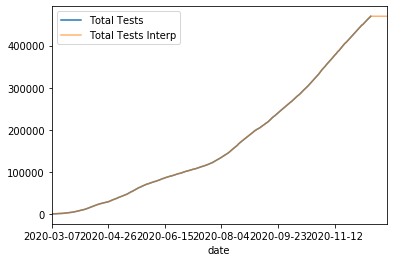

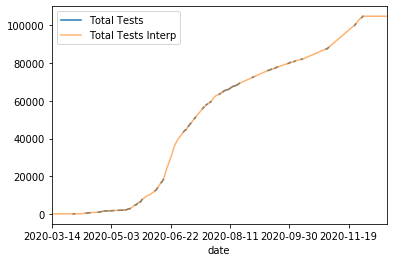

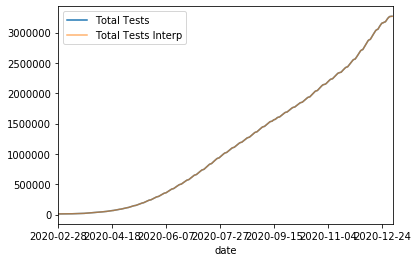

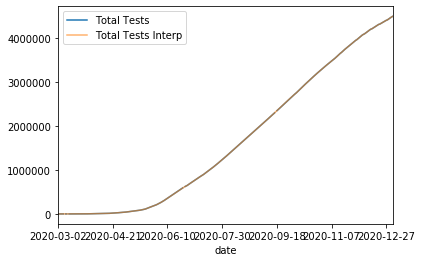

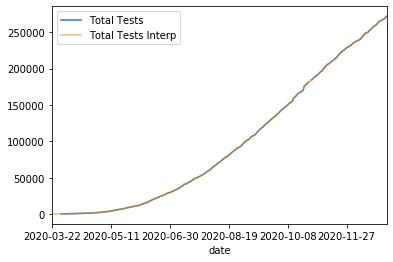

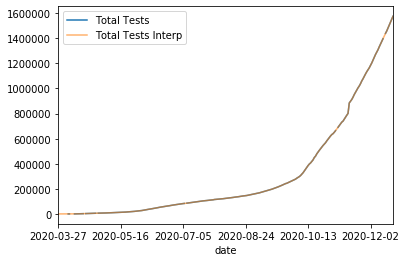

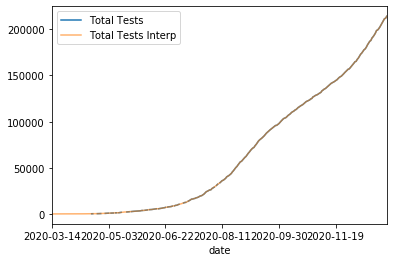

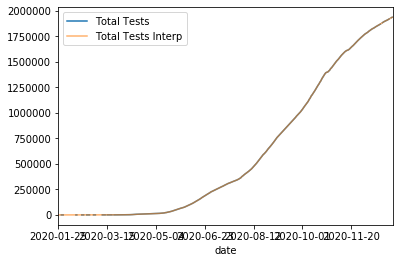

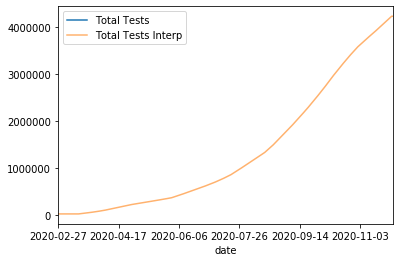

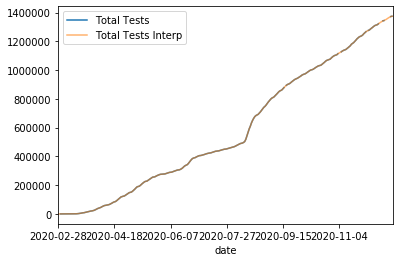

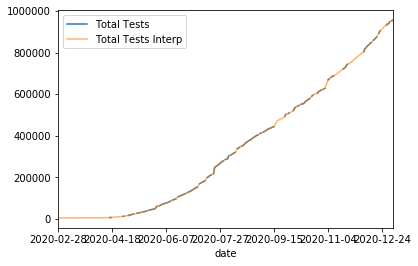

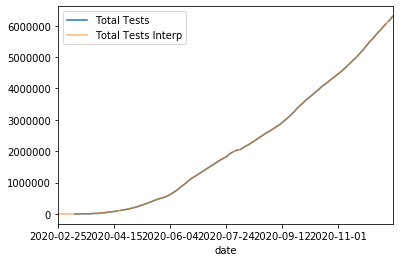

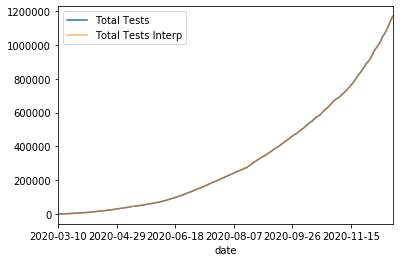

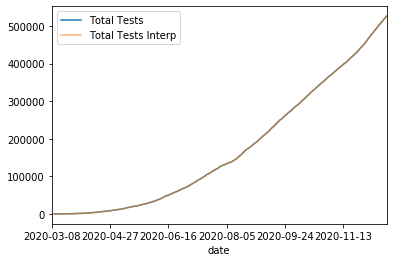

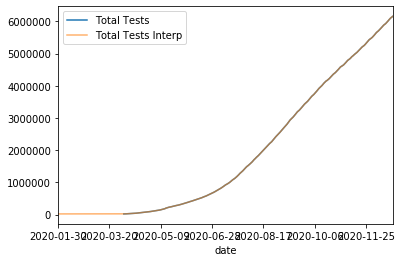

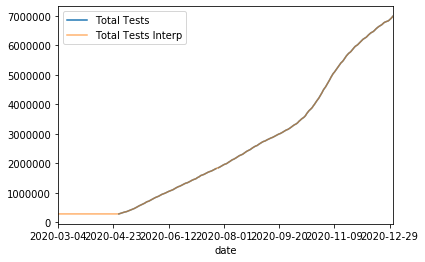

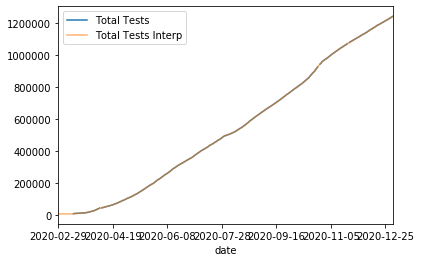

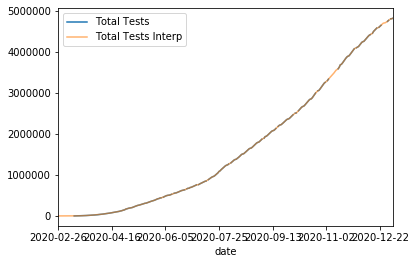

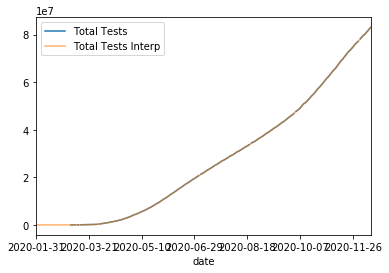

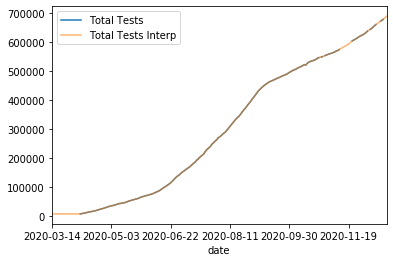

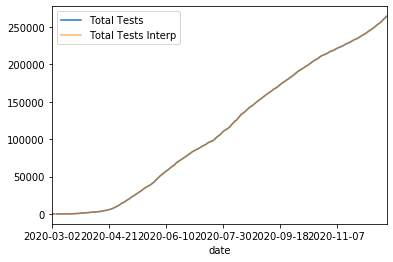

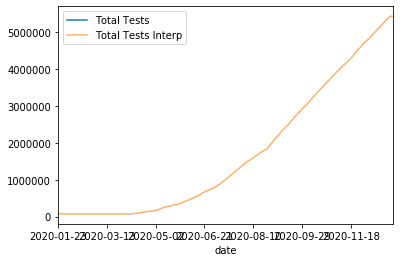

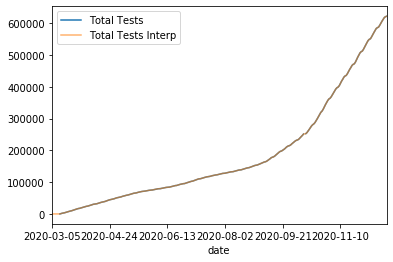

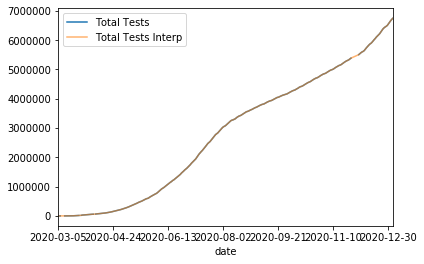

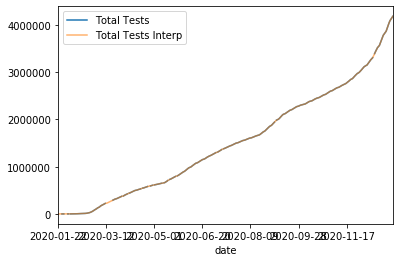

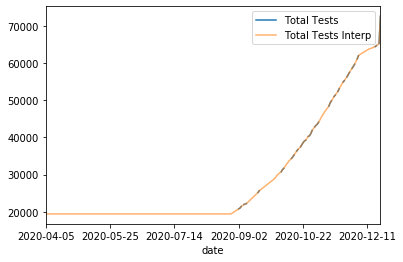

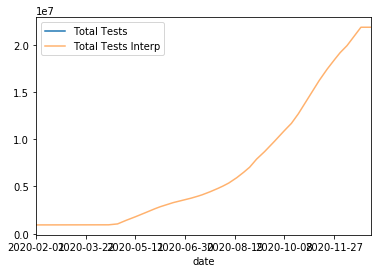

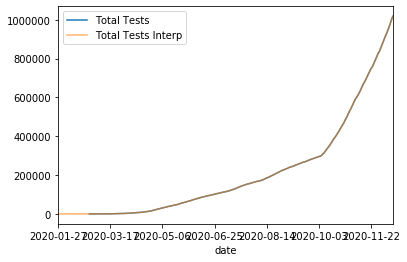

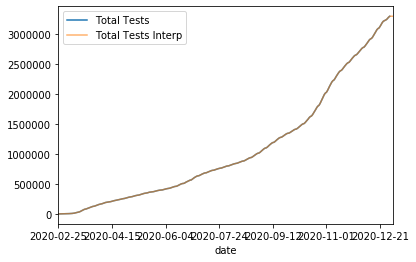

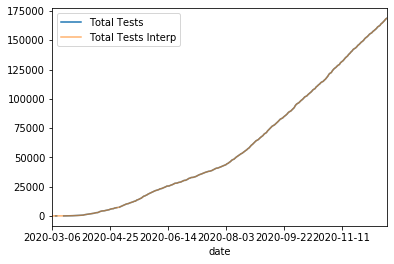

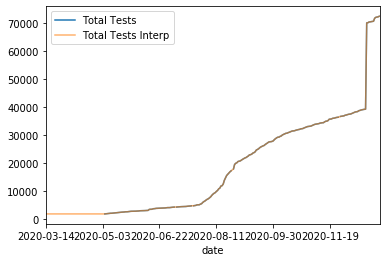

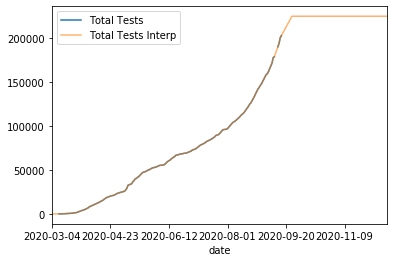

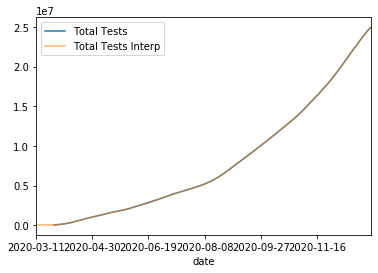

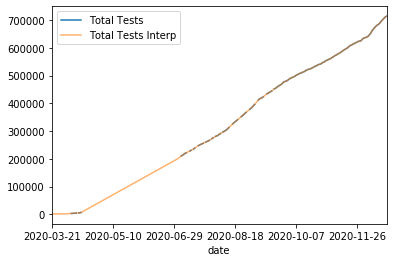

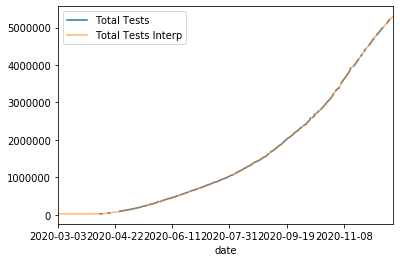

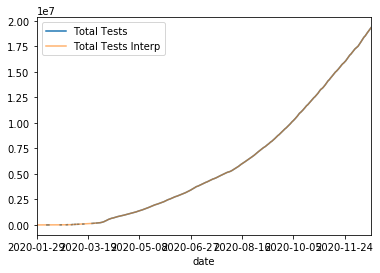

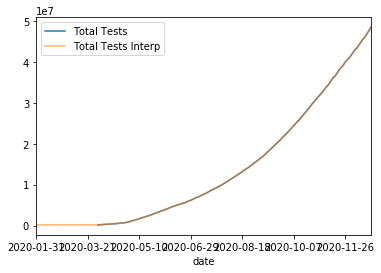

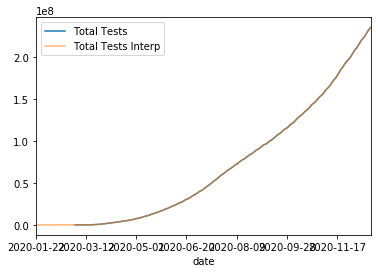

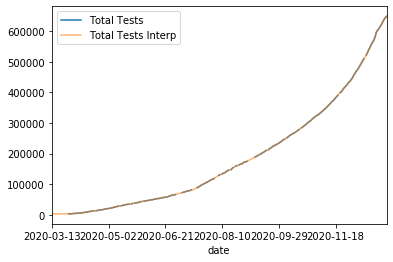

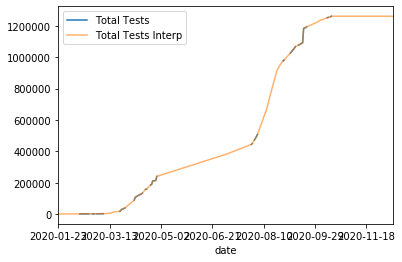

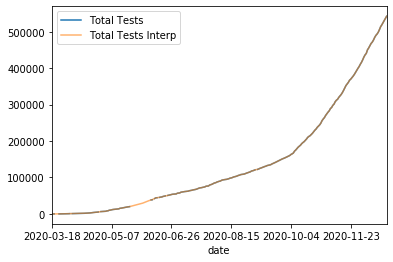

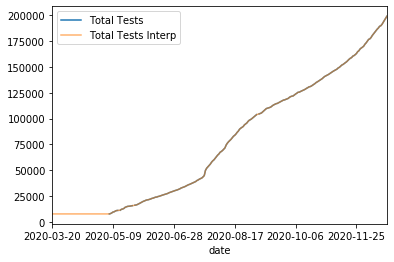

In [77]:
# Interpolate missing total_tests

locations_w_test_data_imp_df = pd.DataFrame(columns=locations_w_test_data_df.columns)

for loc in locations_w_test_data:
    loc_df = locations_w_test_data_df[locations_w_test_data_df["location"]==loc]
    loc_df_imp = loc_df.copy();
    num_missing = loc_df["total_tests"].isna().sum()
    if num_missing>0:
        total_tests_interp = loc_df["total_tests"].interpolate(method ='linear', limit_direction ='both')
        loc_df_imp["total_tests"] = total_tests_interp;
        # assemble df
        locations_w_test_data_imp_df = locations_w_test_data_imp_df.append(loc_df_imp);
        # plot result
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        loc_df.plot(x='date', y='total_tests', kind='line',  ax=ax1)
        loc_df_imp.plot(x='date', y='total_tests', kind='line',  ax=ax1,alpha=0.6)
        ax1.legend(["Total Tests", "Total Tests Interp"])
        plt.show()

In [80]:
locations_w_test_data_imp_df.size

1388348